In [0]:
!pip install cleverhans

    100% |████████████████████████████████| 204kB 22.7MB/s 
    100% |████████████████████████████████| 71kB 5.4MB/s 


# Adversarial examples with Neural Fingerprinting
## Reproducibility Challenge


This Jupyter Notebook contains all code used to reproduce the results of [this paper](https://openreview.net/pdf?id=SJekyhCctQ).

The code is also accessible at the following address: [Github Repository](https://github.com/ptrcarta/ML-project).

The Jupyter Notebook use *Tensorflow low-level API* and *cleverhans* to execute the adversarial attacks.


We start loading all dependencies needed

In [0]:
import time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import cleverhans
from cleverhans.loss import CrossEntropy
from cleverhans.dataset import MNIST
from cleverhans.utils_tf import model_eval
from cleverhans.train import train
from cleverhans.attacks import FastGradientMethod, SaliencyMapMethod
from cleverhans.attacks import CarliniWagnerL2, BasicIterativeMethod
from cleverhans.utils import AccuracyReport, set_log_level
from cleverhans.model import Model

np.random.seed(42)

### Neural Fingerprint

We define the NeuralFingerprinting class that define the Neural Fingerprinting model as descripted in the paper. 

Neural fingerprints usually appear just at the end of the network, after returning logits. In case of simple networks we test them on, we can wrap them into class.

In [0]:
class NeuralFingerprinting:
    # Define Settings
    alpha = 0.25 # to define delta_y
    beta = 0.75 # to define delta_y
    
    def __init__(self, features_tr, labels_tr, features_tst, labels_tst, num_class, eps=0.1, fp_num=5):
        self.num_class = num_class
        self.features_tr = features_tr
        self.labels_tr = labels_tr
        self.features_tst = features_tst
        self.labels_tst = labels_tst
        self.eps = eps
        self.fp_num = fp_num
        
    def compute_dx_dy(self):
        self.dx = np.random.rand(self.fp_num, *self.features_tr.shape[1:]) * self.eps
        
        self.dy = +np.ones((self.num_class, self.num_class)) * self.alpha
        for i in range(self.num_class):
            self.dy[i, i] = -self.beta
        
    def set_nn(self, nn):
        self.nn = nn

    def normalize(self, logits):
        """Used for FxDx """
        return logits / tf.sqrt(tf.reduce_sum(logits**2, axis=-1))[..., None]
    
    
    def construct_graph(self):
        """Need to be called only once."""
        tf.reset_default_graph()
        IS_TRAIN = 1
        tf.keras.backend.set_learning_phase(IS_TRAIN)
        
        
        self.features = tf.placeholder(tf.float32, (None,) + self.features_tr.shape[1:])
        self.labels = tf.placeholder(tf.int64, [None])
        self.dx_tf = tf.constant(self.dx, dtype=tf.float32)
        dy_tf = tf.constant(self.dy, dtype=self.dx_tf.dtype)
        self.batch_size = tf.placeholder(tf.int64)
        
        
        # construct batch dataset to be feed-in into the tf graph
        dataset = tf.data.Dataset.from_tensor_slices((self.features, self.labels))
        batched_dataset = dataset.batch(self.batch_size)
        self.iterator = batched_dataset.make_initializable_iterator()
        self.features_batch, self.labels_batch = self.iterator.get_next()

        # one hoe encode the NUM_CLASS 
        labels_oh = tf.one_hot(self.labels_batch, self.num_class)

        # construct the neural network object  
        self.network = self.nn(self.features_batch.shape[1:], self.num_class)

        logits = self.network(self.features_batch)

        # compute loss vanilla and accuracy
        # TODO LOGITS
        self.loss_vanilla = tf.losses.softmax_cross_entropy(labels_oh, logits)
        self.prediction = tf.argmax(tf.nn.softmax(logits), axis=1)
        prediction_correct = tf.equal(self.prediction, self.labels_batch)
        self.accuracy = tf.reduce_mean(tf.cast(prediction_correct, tf.float32))

        # equivalent to 'x + dx' on the paper
        perturbed_input = tf.reshape(
            self.features_batch[tf.newaxis] + self.dx_tf[:, tf.newaxis],
            (-1,) + self.features_tr.shape[1:]
        )

        # equivalent to phi('x + dx') on the paper
        fp_logits = tf.reshape(
             self.network(perturbed_input),
            (self.fp_num, tf.shape(self.features_batch)[0], self.num_class)
        )

        # FP_NUM x BATCH_SIZE x NUM_LOGITS
        self.FxDx = self.normalize(fp_logits) - self.normalize(logits) # the paper shows it in <- this order but it's then not optimizable
        # FxDx = normalize(logits) - normalize(fp_logits)
        self.Dy = tf.gather(dy_tf, self.labels_batch) # FP_NUM x BATCH_SIZE x NUM_LOGITS

        # Same Dy used for each fingerprint (like in paper)
        self.Dy = tf.stack([self.Dy] * self.fp_num)

        # sum of appropriate means for all fingerprints
        self.loss_fp = tf.reduce_sum(
            # mean of || FxDx - Dy || ^ 2 over batch
            tf.reduce_mean(
                # || FxDx - Dy || ^ 2
                tf.reduce_sum((self.FxDx - self.Dy)**2, axis=-1),
                axis=-1
            ))

        diff_squared = (tf.expand_dims(self.FxDx, 2) - dy_tf) ** 2
        comparison_norm = tf.sqrt(tf.reduce_sum(diff_squared, axis=-1))
        norm_transposed = tf.transpose(comparison_norm, [1, 2, 0])
        self.fingerprint_comparison = tf.reduce_min(tf.reduce_mean(norm_transposed, axis=-1), axis=-1)

        loss = self.loss_vanilla + self.loss_fp
        self.train = tf.train.AdamOptimizer(.001).minimize(loss)
        
    def train_model(self, epoch=1, batch_size=500, verbose=False):
        print("Start training")
        # train
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.losses_fp = []
        self.losses_vanilla = []
        for epoch in range(epoch):
            self.sess.run(self.iterator.initializer, {self.labels:self.labels_tr, self.features:self.features_tr, self.batch_size: batch_size})
            batch_num = 0
            if verbose:
                print('epoch:', epoch)
            i = 0
            while True:

                try:  
                    _, training_loss_fp, training_loss_vanilla = self.sess.run([self.train, self.loss_fp, self.loss_vanilla])

                    if (( i % 100 == 0 and verbose ) or (i % 1000 == 0)):
                        print('fp_loss: %.3f\tvanilla: %.3f\ttotal: %.3f' % (training_loss_fp, training_loss_vanilla, training_loss_fp + training_loss_vanilla))
                    i = i + 1

                    self.losses_fp.append(training_loss_fp)
                    self.losses_vanilla.append(training_loss_vanilla)
                    batch_num += 1

                except tf.errors.OutOfRangeError:
                    break
        print("Train finished.")
    
    
    def display_loss(self):
        plt.plot(self.losses_fp, label="fingerprint")
        plt.plot(self.losses_vanilla, label="vanilla")
        plt.title("loss fingerprint + loss vanilla functions")
        plt.xlabel("iterations")
        plt.ylabel("loss value")
        plt.legend()
        plt.show()
        
    def verify_fp(self):
        # VERIFY FINGERPRINTS
        self.sess.run(self.iterator.initializer, feed_dict={self.labels:self.labels_tst, self.features:self.features_tst, self.batch_size:50})
        fb, fxdx, dy, lv, lfp = self.sess.run([self.features_batch, self.FxDx, self.Dy, self.loss_vanilla, self.loss_fp])
        i = 3
        print(dy[1, i])
        print(fxdx[1, i])
        print("Loss Vanlla: ", lv)
        print("Loss FP:", lfp)
        
        
    def display_test_acc(self):
        tf.keras.backend.set_learning_phase(0)
        self.sess.run(self.iterator.initializer, {self.labels:self.labels_tst, self.features:self.features_tst, self.batch_size:10000})
        print("Test accuracy: ", self.sess.run(self.accuracy))
    
    def get_test_acc(self):
        tf.keras.backend.set_learning_phase(0)
        self.sess.run(self.iterator.initializer, {self.labels:self.labels_tst, self.features:self.features_tst, self.batch_size:10000})
        return self.sess.run(self.accuracy)
    

# 1. Gaussian Balls

Our first experiment for testing the Neural Fingerprint is a toy example: Gaussian Balls.

First, we build the dataset:

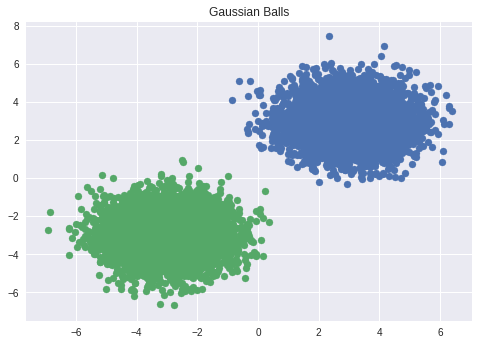

In [0]:
# Build the dataset

N = 10000
norm00 = np.random.multivariate_normal([-3, -3], [[1, 0], [0, 1]], size=N // 2)
norm11 = np.random.multivariate_normal([3, 3], [[1, 0], [0, 1]], size=N // 2)

labels_np = np.int64(np.hstack((np.zeros(norm00.shape[0]),
                                np.ones(norm11.shape[0])
                                )))
features_np = np.float32(np.vstack((norm00, norm11)))
data = np.hstack([features_np, labels_np[:, None]])
np.random.shuffle(data)

labels_np, features_np = np.intp(data[:, -1]), np.float32(data[:, :2])

cut = N * 2 // 3
features_training_np, labels_training_np = features_np[:cut], labels_np[:cut]
features_testing_np, labels_testing_np = features_np[cut:], labels_np[cut:]

plt.scatter(x=norm11[:,0], y=norm11[:,1])
plt.scatter(x=norm00[:,0], y=norm00[:,1])
plt.title("Gaussian Balls")
plt.show()

then, we instantiate the object nf_gauss, compute fingerprints dx and dy and define a simple neural network model

In [0]:
nf_gauss = NeuralFingerprinting(features_training_np, labels_training_np, features_testing_np, labels_testing_np, num_class=2, eps=5)
nf_gauss.compute_dx_dy()
nf_gauss.dy[0]

array([-0.75,  0.25])

In [0]:
# Define the models
def gauss_nn(input_shape, num_class):
    model = tf.keras.Sequential((
        tf.keras.layers.Dense(
            200, activation='relu', input_shape=input_shape,
            kernel_initializer=tf.initializers.truncated_normal,
            bias_initializer=tf.initializers.truncated_normal
        ),
        tf.keras.layers.Dense(
            200, activation='relu',
            kernel_initializer=tf.initializers.truncated_normal,
            bias_initializer = tf.initializers.truncated_normal
        ),
        tf.keras.layers.Dense(num_class, activation=None,
            kernel_initializer=tf.initializers.truncated_normal,
            bias_initializer = tf.initializers.truncated_normal
        )
    ))

    return model


In [0]:
nf_gauss.set_nn(gauss_nn)
nf_gauss.construct_graph()
nf_gauss.train_model(epoch=50, batch_size=500, verbose=False)

Start training
fp_loss: 7.266	vanilla: 104.167	total: 111.433
fp_loss: 3.439	vanilla: 0.000	total: 3.439
fp_loss: 3.110	vanilla: 0.000	total: 3.110
fp_loss: 2.910	vanilla: 0.000	total: 2.910
fp_loss: 2.643	vanilla: 0.000	total: 2.643
fp_loss: 2.220	vanilla: 0.496	total: 2.716
fp_loss: 2.137	vanilla: 0.001	total: 2.138
fp_loss: 2.029	vanilla: 0.011	total: 2.040
fp_loss: 1.959	vanilla: 0.015	total: 1.974
fp_loss: 1.906	vanilla: 0.011	total: 1.916
fp_loss: 1.891	vanilla: 0.019	total: 1.910
fp_loss: 1.878	vanilla: 0.007	total: 1.885
fp_loss: 1.872	vanilla: 0.009	total: 1.881
fp_loss: 1.840	vanilla: 0.006	total: 1.845
fp_loss: 1.781	vanilla: 0.013	total: 1.794
fp_loss: 1.715	vanilla: 0.033	total: 1.748
fp_loss: 1.649	vanilla: 0.079	total: 1.729
fp_loss: 1.644	vanilla: 0.074	total: 1.717
fp_loss: 1.639	vanilla: 0.068	total: 1.707
fp_loss: 1.571	vanilla: 0.191	total: 1.762
fp_loss: 1.584	vanilla: 0.114	total: 1.698
fp_loss: 1.612	vanilla: 0.060	total: 1.672
fp_loss: 1.584	vanilla: 0.083	total

In [0]:
nf_gauss.display_test_acc()

Test accuracy:  0.985003


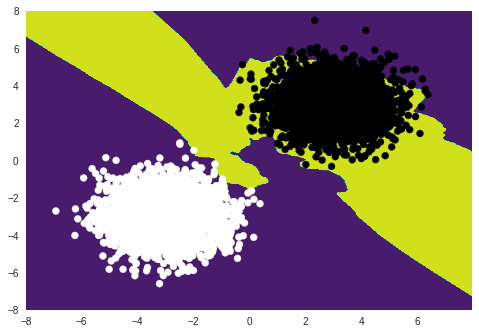

In [0]:
x, y = np.mgrid[-8:8:0.04, -8:8:0.03]

# plot decision boundaries
prediction_np = nf_gauss.sess.run(nf_gauss.prediction, feed_dict={
                  nf_gauss.features_batch: np.dstack((x, y)).reshape((-1, 2))})

plt.contourf(x, y, prediction_np.reshape(x.shape), cmap='viridis')

plt.scatter(features_training_np[:, 0],
            features_training_np[:, 1], c=labels_training_np)


plt.show()

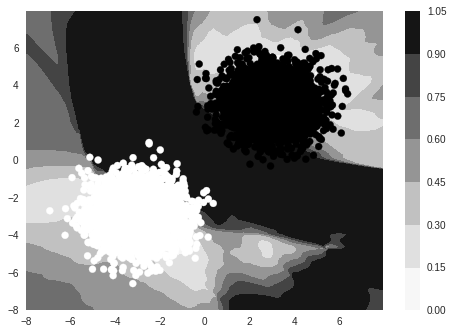

In [0]:
# plot fingerprint loss
x, y = np.mgrid[-8:8:0.05, -8:8:0.05]
dissimilarities = nf_gauss.sess.run(nf_gauss.fingerprint_comparison, feed_dict={nf_gauss.features_batch: np.dstack(
    (x, y)).reshape((-1, 2)), nf_gauss.dx_tf: nf_gauss.dx})
plt.contourf(x, y, np.clip(dissimilarities.reshape(x.shape), 0, 1))
plt.colorbar()
plt.scatter(features_training_np[:, 0],
            features_training_np[:, 1], c=labels_training_np)
plt.show()

## 2 MNIST

Run several fingerprint experiments on MNIST data.

### 2.1 Load the data

Use the Tensorflow Dataset API to download the data and save it in a Tensor variable:

In [0]:
(features_tr, labels_tr), (features_tst, labels_tst) = tf.keras.datasets.mnist.load_data()
features_tr = features_tr[...,np.newaxis]
features_tst = features_tst[...,np.newaxis]

features_tr = features_tr.astype(np.float32)
features_tst = features_tst.astype(np.float32)

# Normalize the dataset
features_tr /= 255.0
features_tr -= 0.5
features_tst /= 255.0
features_tst -= 0.5

# Randomize datasets
tr_idxs = np.random.permutation(len(features_tr))
features_tr, labels_tr = features_tr[tr_idxs], labels_tr[tr_idxs]
tst_idxs = np.random.permutation(len(features_tst))
features_tst, labels_tst = features_tst[tst_idxs], labels_tst[tst_idxs]

### 2.2 Initialize model

In [0]:
nf_mnist = NeuralFingerprinting(features_tr, labels_tr, features_tst, labels_tst, num_class=10)

### 2.3 Compute delta_x and delta_y (fingerprints)

In [0]:
nf_mnist.compute_dx_dy()
nf_mnist.dy[0]

array([-0.75,  0.25,  0.25,  0.25,  0.25,  0.25,  0.25,  0.25,  0.25,
        0.25])

### 2.4 Define Neural Nertwork structure to train the MNIST model

Use the same as "Table 8" of the paper. Do not use BatchNormalization since it returns worse results.

In [0]:
def mnist_nn(input_shape, num_class):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(
                32,
                (5,5),
                activation = 'relu',
                input_shape = input_shape
        ),
        tf.keras.layers.MaxPool2D(),

        tf.keras.layers.Conv2D(
                64,
                (5,5),
                activation = 'relu'
        ),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200, activation='relu'),
        # tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(200, activation='relu'),
        # tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(num_class, activation=None)
    ])
    return model

### 2.5 Set the Neural Network to the model, construct the graph and train the model

In [0]:
nf_mnist.set_nn(mnist_nn)
nf_mnist.construct_graph()
nf_mnist.train_model(epoch=10, batch_size=500, verbose=True)

Start training
epoch: 0
fp_loss: 5.713	vanilla: 2.301	total: 8.014
fp_loss: 0.839	vanilla: 2.197	total: 3.037
epoch: 1
fp_loss: 0.666	vanilla: 2.168	total: 2.834
fp_loss: 0.447	vanilla: 1.815	total: 2.262
epoch: 2
fp_loss: 0.434	vanilla: 1.597	total: 2.031
fp_loss: 0.335	vanilla: 0.356	total: 0.692
epoch: 3
fp_loss: 0.305	vanilla: 0.232	total: 0.537
fp_loss: 0.226	vanilla: 0.105	total: 0.331
epoch: 4
fp_loss: 0.227	vanilla: 0.084	total: 0.310
fp_loss: 0.185	vanilla: 0.050	total: 0.235
epoch: 5
fp_loss: 0.178	vanilla: 0.059	total: 0.236
fp_loss: 0.156	vanilla: 0.032	total: 0.188
epoch: 6
fp_loss: 0.151	vanilla: 0.045	total: 0.195
fp_loss: 0.126	vanilla: 0.025	total: 0.150
epoch: 7
fp_loss: 0.129	vanilla: 0.034	total: 0.163
fp_loss: 0.098	vanilla: 0.022	total: 0.120
epoch: 8
fp_loss: 0.129	vanilla: 0.025	total: 0.154
fp_loss: 0.086	vanilla: 0.021	total: 0.106
epoch: 9
fp_loss: 0.104	vanilla: 0.023	total: 0.126
fp_loss: 0.078	vanilla: 0.019	total: 0.097
Train finished.


### 2.6 Display loss graph, verify fingerprints work as expected and display test accuracy

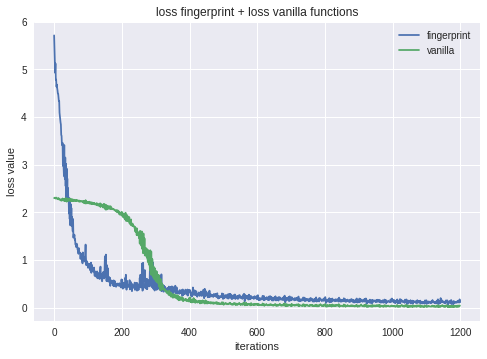

[ 0.25  0.25  0.25 -0.75  0.25  0.25  0.25  0.25  0.25  0.25]
[ 0.20787144  0.20532945  0.20975061 -0.7703324   0.19845475  0.19132353
  0.21309502  0.22193144  0.20222443  0.17304882]
Loss Vanlla:  0.030755999
Loss FP: 0.1070018
Test accuracy:  0.9902


In [0]:
nf_mnist.display_loss()
nf_mnist.verify_fp()
nf_mnist.display_test_acc()

From the results above we can have a confirmation that the training phase worked correctly since the values of fxdx are similar to the expected value dy, i.e NUM_CLASS -1 values are ~ -0.25 and one values is ~ +0.75.

### 2.7 Attack the model

define a class to manage the different adversarial attacks:

In [0]:
def plot_roc_auc(attacks, fprs, tprs, roc_aucs):
    for i in range(len(attacks)):
        plt.plot(fprs[i], tprs[i],
                 label='{} ROC curve (area = {})'.format(
                     attacks[i], roc_aucs[i]
                 ))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    
class AttackEvaluator(object):
    CLIP_MIN = - 0.5
    CLIP_MAX = 0.5

    ATTACK_PARAMS = {
      'fgsm': ({
          'clip_min': CLIP_MIN,
          'clip_max': CLIP_MAX
      }, FastGradientMethod),
      
      'bim': ({
          'eps_iter': 0.01,
          'clip_min': CLIP_MIN,
          'clip_max': CLIP_MAX,
          'nb_iter': 50
      }, BasicIterativeMethod),
      
      # Attacks not used
      'jsma': ({
          'clip_min': CLIP_MIN,
          'clip_max': CLIP_MAX,
          'theta': 1.0,
          'gamma': 0.1
      }, SaliencyMapMethod),

      'cw-l2': ({
          'binary_search_steps': 1,
          'max_iterations': 1000,
          'learning_rate': 0.2,
          'initial_const': 10
      }, CarliniWagnerL2),
  }
  
    ADV_EXAMPLES = 100
  
    def __init__(self, method, model, nf, threshold = 0.5):
        self.attack_params = self.ATTACK_PARAMS[method][0]
        
        self.model = model
        self.nf = nf
        
        if method == 'fgsm' or method == 'bim':
            self.ATTACK_PARAMS[method][0]['eps'] = self.nf.eps

        self.generator = self.ATTACK_PARAMS[method][1](self.model, self.nf.sess)
        self.threshold = 0.5
        self.xs = self.nf.features_tst[:self.ADV_EXAMPLES]
        self.ys = self.nf.labels_tst[:self.ADV_EXAMPLES]
        self.attacked = False
 
    def attack(self):
        self.adv_xs = self.generator.generate_np(self.xs, **self.attack_params)
        self.legit_losses = self.nf.sess.run(self.nf.fingerprint_comparison, feed_dict={
            self.nf.features_batch: self.xs})
        self.adv_losses = self.nf.sess.run(self.nf.fingerprint_comparison, feed_dict={
                self.nf.features_batch: self.adv_xs})
        self.attacked = True
    
    def display_real_fake_plot(self):
        if self.attacked:
            plt.scatter(np.arange(
                len(self.legit_losses)), 
                        self.legit_losses, 
                        label='True examples')
            plt.scatter(
                np.arange(len(self.adv_losses)), 
                self.adv_losses,
            label='Adversarial examples')
            
            plt.axis('off')
            plt.xlabel('Test Example')
            plt.ylabel('Fingerprint Loss')
            plt.legend(loc="best")        
        
    def get_auc_roc_data(self):
        X = np.concatenate((self.adv_losses, self.legit_losses))
        Y = np.array([1] * self.ADV_EXAMPLES + [0] * self.ADV_EXAMPLES)
        fpr, tpr, _ = roc_curve(Y, X)
        roc_auc = auc(fpr, tpr)
        return fpr, tpr, roc_auc
    
    def display_image_attack(self, columns = 2, rows = 3):
        w = 5
        h = 5

        fig = plt.figure(figsize=(4, 4))

        for i in range(1,rows+1):

            # original
            fig.add_subplot(rows, columns, i*2-1)
            plt.imshow(features_tst[i-1,...,0] + 0.5)
            plt.title("original")

            # attack
            fig.add_subplot(rows, columns, i*2)
            plt.imshow(self.adv_xs[i-1,...,0] + 0.5)
            plt.title("attack")
        plt.axis('off')
        plt.show()
        
        
    def get_test_accuracy(self):
        if not self.attacked:
            raise Exception("You need to call attack() first")
            
        return self.nf.sess.run(self.nf.accuracy, feed_dict={
            self.nf.features_batch: self.adv_xs, self.nf.labels_batch: self.ys
        })

#### 2.7.1 FastGradientMethod attack

[INFO 2018-12-20 20:17:26,647 cleverhans] Constructing new graph for attack FastGradientMethod


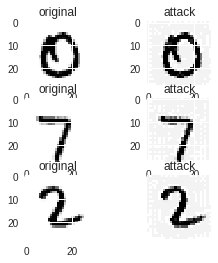

In [0]:
class MnistModel(Model):
    def fprop(self, x, **kwargs):
        return {
            self.O_LOGITS: nf_mnist.network(x),
        }
      

mnist_fgsm_attack = AttackEvaluator('fgsm', MnistModel(), nf_mnist)
mnist_fgsm_attack.attack()
mnist_fgsm_attack.display_image_attack()

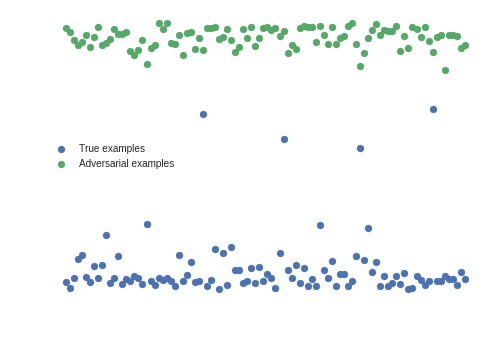

In [0]:
mnist_fgsm_attack.display_real_fake_plot()

In [0]:
print("Network accuracy on FGSM examples: {}".format(
    mnist_fgsm_attack.get_test_accuracy()
))

Network accuracy on FGSM examples: 0.0


### 2.7.2 BIM attack

[INFO 2018-12-20 20:17:27,767 cleverhans] Constructing new graph for attack BasicIterativeMethod


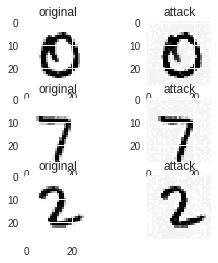

In [0]:
mnist_bim_attack = AttackEvaluator('bim', MnistModel(), nf_mnist)
mnist_bim_attack.attack()
mnist_bim_attack.display_image_attack()

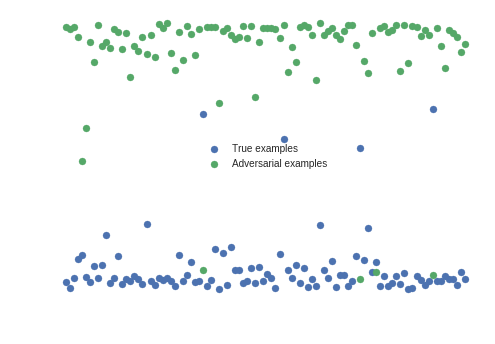

In [0]:
mnist_bim_attack.display_real_fake_plot()

In [0]:
print("Network accuracy on BIM examples: {}".format(mnist_bim_attack.get_test_accuracy()))

Network accuracy on BIM examples: 0.019999999552965164


#### 2.7.3 FGSM + BIM AUC-ROC

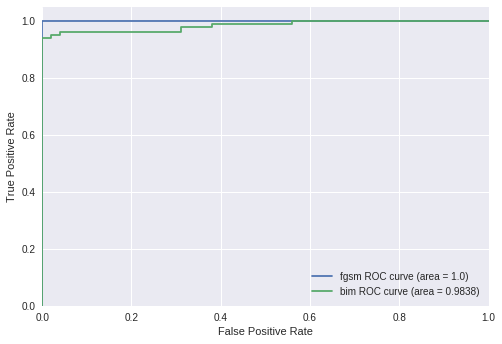

In [0]:
fpr_fgsm, tpr_fgsm, roc_auc_fgsm = mnist_fgsm_attack.get_auc_roc_data()
fpr_bim, tpr_bim, roc_auc_bim = mnist_bim_attack.get_auc_roc_data()
plot_roc_auc(
    ['fgsm', 'bim'],
    [fpr_fgsm, fpr_bim],
    [tpr_fgsm, tpr_bim],
    [roc_auc_fgsm, roc_auc_bim]
)

## 3. CIFAR 10

We execute now the same analysis for CIFAR10.

### 3.1 Load the data

In [0]:
(features_tr, labels_tr), (features_tst, labels_tst) = \
    tf.keras.datasets.cifar10.load_data()
labels_tr = labels_tr[:,0]
labels_tst = labels_tst[:,0]

features_tr = features_tr.astype(np.float32)
features_tst = features_tst.astype(np.float32)

features_tr /= 255.0
features_tr -= 0.5
features_tst /= 255.0
features_tst -= 0.5

tr_idxs = np.random.permutation(len(features_tr))
features_tr, labels_tr = features_tr[tr_idxs], labels_tr[tr_idxs]
tst_idxs = np.random.permutation(len(features_tst))
features_tst, labels_tst = features_tst[tst_idxs], labels_tst[tst_idxs]

### 3.2 Define the model

In [0]:
def cifar10_nn(input_shape, num_class):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(
                32,
                (3,3),
                activation = 'relu',
                input_shape = input_shape
        ),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(
                64,
                (3,3),
                activation = 'relu'
        ),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(
                128,
                (3,3),
                activation = 'relu'
        ),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(
                128,
                (3,3),
                activation = 'relu'
        ),
        #tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.MaxPool2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(num_class, activation=None)
    ])
    return model

### 3.3 Train the model with fingerprints

Start training
fp_loss: 6.599	vanilla: 3.054	total: 9.652
fp_loss: 4.249	vanilla: 1.313	total: 5.562
fp_loss: 2.972	vanilla: 0.958	total: 3.930
fp_loss: 2.304	vanilla: 0.766	total: 3.070
fp_loss: 1.943	vanilla: 0.664	total: 2.606
fp_loss: 1.668	vanilla: 0.544	total: 2.212
fp_loss: 1.435	vanilla: 0.431	total: 1.866
fp_loss: 1.284	vanilla: 0.386	total: 1.670
fp_loss: 1.130	vanilla: 0.329	total: 1.459
fp_loss: 0.995	vanilla: 0.284	total: 1.280
Train finished.


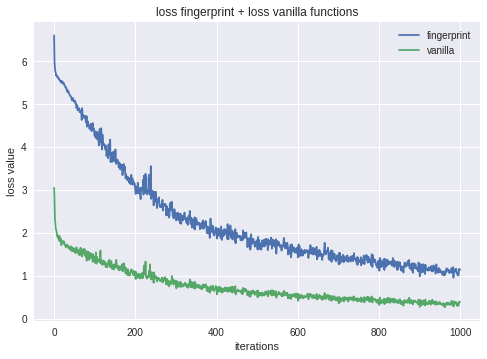

[ 0.25  0.25  0.25  0.25 -0.75  0.25  0.25  0.25  0.25  0.25]
[ 0.40098384  0.3673672   0.48811674 -0.3091181   0.06810912 -0.04582417
  0.4765913   0.19251096  0.3419354   0.19225371]
Loss Vanlla:  1.1110947
Loss FP: 2.7584562
Test accuracy:  0.756


In [0]:
nf_cifar10 = NeuralFingerprinting(features_tr, labels_tr, features_tst,
                                  labels_tst, num_class=10)
nf_cifar10.compute_dx_dy()

nf_cifar10.set_nn(cifar10_nn)
nf_cifar10.construct_graph()
nf_cifar10.train_model(epoch=10, batch_size=500)

nf_cifar10.display_loss()
nf_cifar10.verify_fp()
nf_cifar10.display_test_acc()

### 3.4 Attack the model

#### 3.4.1 Fast Gradient Sign attack

[INFO 2018-12-20 20:25:33,669 cleverhans] Constructing new graph for attack FastGradientMethod


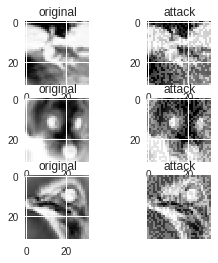

In [0]:
class Cifar10Model(Model):
    def fprop(self, x, **kwargs):
        return {
            self.O_LOGITS: nf_cifar10.network(x),
        }
    

cifar10_fgsm_attack = AttackEvaluator('fgsm', Cifar10Model(), nf_cifar10)
cifar10_fgsm_attack.attack()
cifar10_fgsm_attack.display_image_attack()

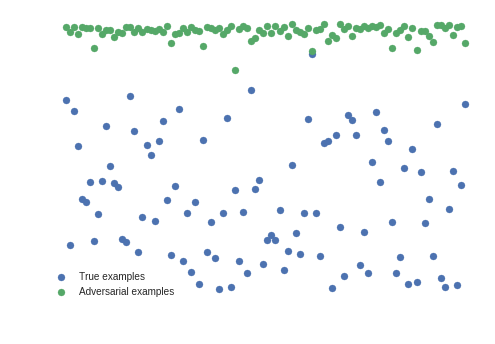

In [0]:
cifar10_fgsm_attack.display_real_fake_plot()

In [0]:
print("Network accuracy on FGSM examples: {}".format(cifar10_fgsm_attack.get_test_accuracy()))

Network accuracy on FGSM examples: 0.15000000596046448


#### 3.4.2 BIM attack

[INFO 2018-12-20 20:25:35,116 cleverhans] Constructing new graph for attack BasicIterativeMethod


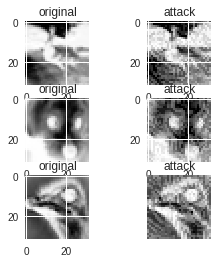

In [0]:
cifar10_bim_attack = AttackEvaluator('bim', Cifar10Model(), nf_cifar10)
cifar10_bim_attack.attack()
cifar10_bim_attack.display_image_attack()

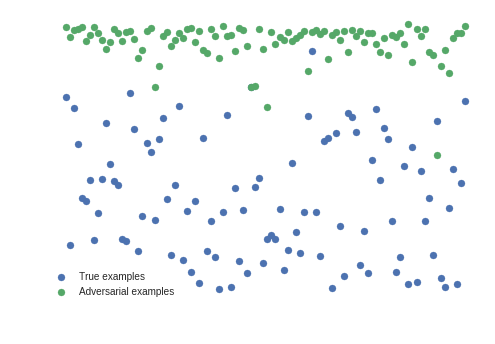

In [0]:
cifar10_bim_attack.display_real_fake_plot()

In [0]:
print("Network accuracy on BIM examples: {}".format(cifar10_bim_attack.get_test_accuracy()))

Network accuracy on BIM examples: 0.20999999344348907


#### 3.4.3 FGSM + BIM AUC-ROC

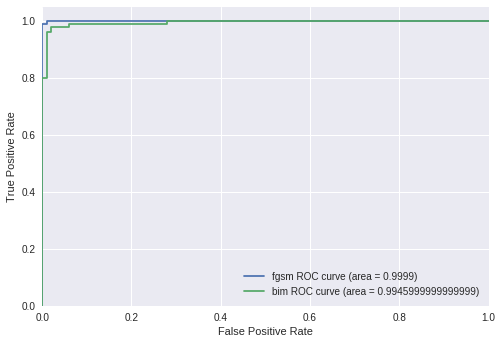

In [0]:
fpr_fgsm, tpr_fgsm, roc_auc_fgsm = cifar10_fgsm_attack.get_auc_roc_data()
fpr_bim, tpr_bim, roc_auc_bim = cifar10_bim_attack.get_auc_roc_data()
plot_roc_auc(
    ['fgsm', 'bim'],
    [fpr_fgsm, fpr_bim],
    [tpr_fgsm, tpr_bim],
    [roc_auc_fgsm, roc_auc_bim]
)

As we see, our experiments results are pretty similair to MNIST results.

## 4. Varying number of fingerprints N

For our final set of experiments, we want to see how varying number of fingerprints affects execution time, network accuracy and adversarial robustness. We'll do that on MNIST dataset, since training MNIST has lowest computational requirements.

### 4.1 Load data

In [0]:
# MNIST dataset loading
(features_tr, labels_tr), (features_tst, labels_tst) = tf.keras.datasets.mnist.load_data()
features_tr = features_tr[...,np.newaxis]
features_tst = features_tst[...,np.newaxis]

features_tr = features_tr.astype(np.float32)
features_tst = features_tst.astype(np.float32)

# Normalize the dataset
features_tr /= 255.0
features_tr -= 0.5
features_tst /= 255.0
features_tst -= 0.5

# Randomize datasets
tr_idxs = np.random.permutation(len(features_tr))
features_tr, labels_tr = features_tr[tr_idxs], labels_tr[tr_idxs]
tst_idxs = np.random.permutation(len(features_tst))
features_tst, labels_tst = features_tst[tst_idxs], labels_tst[tst_idxs]

11493376/11490434 [==============================] - 0s 0us/step


### 4.2 Train the network with 5, 10, 20, 30 fingerprint and see how it affects metrics we measure

In [0]:
ns = [5, 10, 20, 30]

auc_rocs = {
    'bim': [],
    'fgsm': [],
}
execution_times = []
accuracies = []

for n in ns:
    print("N = {}\n".format(n))
    nf = NeuralFingerprinting(
        features_tr, labels_tr, features_tst, labels_tst, num_class=10, fp_num=n)
    nf.compute_dx_dy()
    nf.set_nn(mnist_nn)
    nf.construct_graph()
    
    start_time = time.time()
    nf.train_model(epoch=5, batch_size=500, verbose=True)
    end_time = time.time()
    print("Training time: {}\n".format(end_time - start_time))
    execution_times.append(end_time - start_time)

    accuracy = nf.get_test_acc()
    print("Accuracy: {}\n".format(accuracy))
    accuracies.append(accuracy)

    class MnistModel(Model):
        def fprop(self, x, **kwargs):
            return {
                self.O_LOGITS: nf.network(x),
            }
    
    for attack_method in auc_rocs:
        attack = AttackEvaluator(attack_method, MnistModel(), nf)
        attack.attack()
        _, _, auc_roc = attack.get_auc_roc_data()
        auc_rocs[attack_method].append(auc_roc)

N = 5

Start training
epoch: 0
fp_loss: 5.761	vanilla: 2.295	total: 8.057
fp_loss: 0.885	vanilla: 2.208	total: 3.093
epoch: 1
fp_loss: 0.860	vanilla: 2.195	total: 3.055
fp_loss: 0.528	vanilla: 1.789	total: 2.317
epoch: 2
fp_loss: 0.432	vanilla: 1.652	total: 2.084
fp_loss: 0.405	vanilla: 0.322	total: 0.727
epoch: 3
fp_loss: 0.357	vanilla: 0.269	total: 0.626
fp_loss: 0.308	vanilla: 0.141	total: 0.449
epoch: 4
fp_loss: 0.263	vanilla: 0.106	total: 0.369
fp_loss: 0.255	vanilla: 0.098	total: 0.354


[INFO 2018-12-20 21:30:59,800 cleverhans] Constructing new graph for attack BasicIterativeMethod


Train finished.
Training time: 47.132466077804565

Accuracy: 0.9850000143051147



[INFO 2018-12-20 21:31:00,506 cleverhans] Constructing new graph for attack FastGradientMethod


N = 10

Start training
epoch: 0
fp_loss: 11.628	vanilla: 2.298	total: 13.925
fp_loss: 1.901	vanilla: 2.213	total: 4.114
epoch: 1
fp_loss: 1.981	vanilla: 2.224	total: 4.204
fp_loss: 0.940	vanilla: 2.067	total: 3.007
epoch: 2
fp_loss: 1.331	vanilla: 2.113	total: 3.444
fp_loss: 0.683	vanilla: 1.800	total: 2.483
epoch: 3
fp_loss: 0.619	vanilla: 1.725	total: 2.344
fp_loss: 0.800	vanilla: 0.938	total: 1.738
epoch: 4
fp_loss: 0.637	vanilla: 0.769	total: 1.406
fp_loss: 0.721	vanilla: 0.177	total: 0.898


[INFO 2018-12-20 21:32:24,371 cleverhans] Constructing new graph for attack BasicIterativeMethod


Train finished.
Training time: 82.3589882850647

Accuracy: 0.98580002784729



[INFO 2018-12-20 21:32:25,083 cleverhans] Constructing new graph for attack FastGradientMethod


N = 20

Start training
epoch: 0
fp_loss: 22.436	vanilla: 2.302	total: 24.738
fp_loss: 3.668	vanilla: 2.252	total: 5.920
epoch: 1
fp_loss: 4.046	vanilla: 2.263	total: 6.309
fp_loss: 2.594	vanilla: 2.222	total: 4.817
epoch: 2
fp_loss: 1.712	vanilla: 2.183	total: 3.894
fp_loss: 1.435	vanilla: 2.116	total: 3.551
epoch: 3
fp_loss: 1.119	vanilla: 2.106	total: 3.224
fp_loss: 1.133	vanilla: 2.000	total: 3.133
epoch: 4
fp_loss: 0.993	vanilla: 2.002	total: 2.996
fp_loss: 0.907	vanilla: 1.792	total: 2.699


[INFO 2018-12-20 21:34:59,140 cleverhans] Constructing new graph for attack BasicIterativeMethod


Train finished.
Training time: 152.69242906570435

Accuracy: 0.984499990940094



[INFO 2018-12-20 21:35:00,077 cleverhans] Constructing new graph for attack FastGradientMethod


N = 30

Start training
epoch: 0
fp_loss: 32.871	vanilla: 2.300	total: 35.172
fp_loss: 7.096	vanilla: 2.281	total: 9.377
epoch: 1
fp_loss: 5.191	vanilla: 2.238	total: 7.429
fp_loss: 3.458	vanilla: 2.222	total: 5.680
epoch: 2
fp_loss: 3.301	vanilla: 2.224	total: 5.525
fp_loss: 2.289	vanilla: 2.153	total: 4.441
epoch: 3
fp_loss: 1.894	vanilla: 2.163	total: 4.057
fp_loss: 1.799	vanilla: 2.117	total: 3.917
epoch: 4
fp_loss: 1.365	vanilla: 2.107	total: 3.472
fp_loss: 1.753	vanilla: 2.012	total: 3.765


[INFO 2018-12-20 21:38:48,719 cleverhans] Constructing new graph for attack BasicIterativeMethod


Train finished.
Training time: 227.25507307052612

Accuracy: 0.9674000144004822



[INFO 2018-12-20 21:38:49,640 cleverhans] Constructing new graph for attack FastGradientMethod


### 4.3 AUC-ROC on BIM, FGSM

We see that network robustness raises when more fingerprints are added.

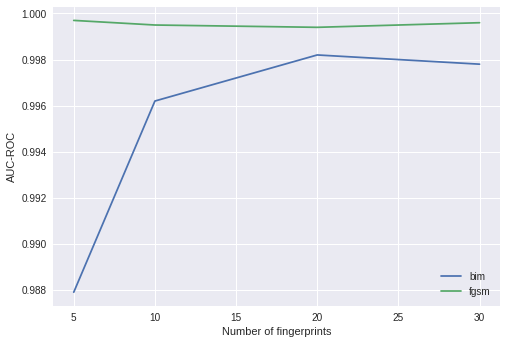

In [0]:
for method in auc_rocs:
    plt.plot(ns, auc_rocs[method], label=method)
plt.xlabel('Number of fingerprints')
plt.ylabel('AUC-ROC')
plt.legend(loc='best')
plt.show()

### 4.4 Accuracy

We see a slight decrease in accuracy, but this is probably since more fingerprints need more epochs to converge, and we've run all training for 5 epochs.

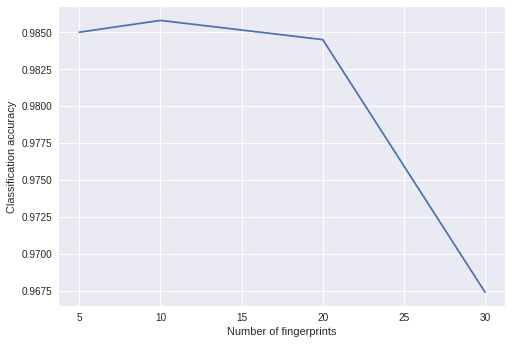

In [0]:
plt.plot(ns, accuracies)
plt.xlabel('Number of fingerprints')
plt.ylabel('Classification accuracy')
plt.show()

### 4.5 Execution time

Execution time gets scaled by number of fingerprints when running the training. It's because each fingerprint causes one additional network inference.

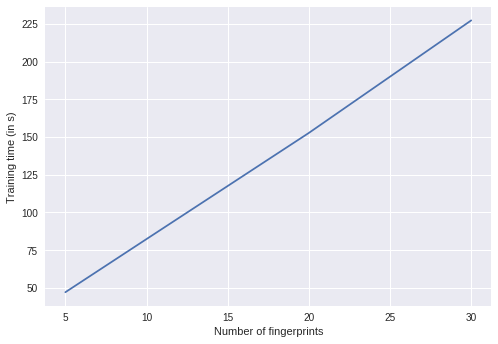

In [0]:
plt.plot(ns, execution_times)
plt.xlabel('Number of fingerprints')
plt.ylabel('Training time (in s)')
plt.show()